
=== Null Values ===
AMT_ANNUITY                        6
AMT_GOODS_PRICE                  129
NAME_TYPE_SUITE                  612
OWN_CAR_AGE                   101647
OCCUPATION_TYPE                48262
                               ...  
AMT_REQ_CREDIT_BUREAU_DAY      20727
AMT_REQ_CREDIT_BUREAU_WEEK     20727
AMT_REQ_CREDIT_BUREAU_MON      20727
AMT_REQ_CREDIT_BUREAU_QRT      20727
AMT_REQ_CREDIT_BUREAU_YEAR     20727
Length: 67, dtype: int64

=== Percentage of Default (1) vs Non-Default (0) ===
TARGET
0    91.91
1     8.09
Name: proportion, dtype: float64

=== Dropping Highly Correlated Features ===
['AMT_GOODS_PRICE', 'FLAG_EMP_PHONE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT_W_CITY', 'LIVE_REGION_NOT_WORK_REGION', 'LIVE_CITY_NOT_WORK_CITY', 'ELEVATORS_AVG', 'LIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVI

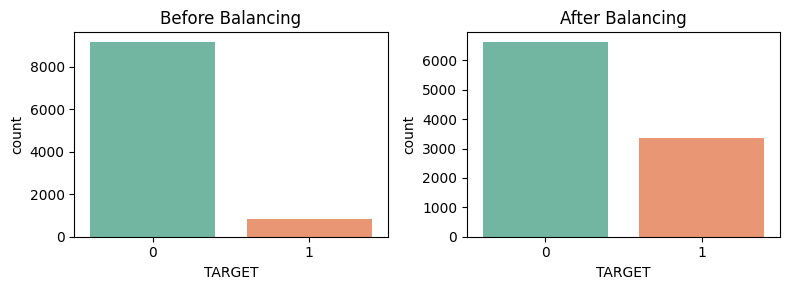

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7697 - loss: 0.4666
Epoch 2/5
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8488 - loss: 0.3596
Epoch 3/5
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8563 - loss: 0.3452
Epoch 4/5
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8584 - loss: 0.3423
Epoch 5/5
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8600 - loss: 0.3369
961/961 ━━━━━━━━━━━━━━━━━━━━ 1s 943us/step

=== Model Evaluation ===
Sensitivity (True Positive Rate): 0.1466
961/961 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
ROC-AUC Score: 0.6772


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Step 1: Data Preparation

# Load dataset with optimized dtypes
dataset_path = 'loan_data.csv'
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Dataset file '{dataset_path}' not found.")

dtypes = {
    'TARGET': 'int8',
    'SK_ID_CURR': 'int32',
    'AMT_INCOME_TOTAL': 'float32',
    'AMT_CREDIT': 'float32',
    'AMT_ANNUITY': 'float32',
    'AMT_GOODS_PRICE': 'float32',
    'DAYS_BIRTH': 'int32',
    'DAYS_EMPLOYED': 'int32'
}
sample_frac = 0.5  # Use 50% of data for faster execution
df = pd.read_csv(dataset_path, dtype=dtypes, low_memory=False).sample(frac=sample_frac, random_state=42)

# Check and handle null values
print("\n=== Null Values ===")
null_counts = df.isnull().sum()
print(null_counts[null_counts > 0])  # Show only columns with nulls
df.fillna(df.median(numeric_only=True), inplace=True)
df.fillna(df.mode().iloc[0], inplace=True)

# Analyze and visualize data imbalance
default_percentage = (df['TARGET'].value_counts(normalize=True) * 100).round(2)
print("\n=== Percentage of Default (1) vs Non-Default (0) ===")
print(default_percentage)

# Step 2 : Feature Engineering

# Separate features and target
X = df.drop(['TARGET', 'SK_ID_CURR'], axis=1)  # Drop ID column
y = df['TARGET']

# Drop highly correlated features
numeric_cols_before_drop = X.select_dtypes(include=['int8', 'int32', 'float32', 'int64', 'float64']).columns
corr_matrix = X[numeric_cols_before_drop].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.8)]  # Threshold: 0.8
print("\n=== Dropping Highly Correlated Features ===")
print(to_drop)
X = X.drop(to_drop, axis=1)

# Encode categorical variables
for col in X.select_dtypes(include=['object', 'category']).columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Print data types to verify encoding
print("\n=== Data Types After Encoding ===")
print(X.dtypes.value_counts())

# Step 3: Exploratory Data Analysis (EDA)
print("\n=== Exploratory Data Analysis ===")

# Summary statistics
print("\nNumerical Summary:")
print(X.describe())
print("\nCategorical Summary:")
print(X.select_dtypes(include=['int32']).describe())  # Assuming encoded categoricals are int32

# Update numeric_cols after dropping features and encoding categoricals
numeric_cols = X.select_dtypes(include=['int8', 'int32', 'float32', 'int64', 'float64']).columns

# Print the number of numeric columns and the list
print(f"\nNumber of numeric columns after processing: {len(numeric_cols)}")
print("\nUpdated list of numeric columns:")
print(numeric_cols.tolist())

# Correlation with TARGET
correlation = X[numeric_cols].corrwith(y).sort_values(ascending=False)
print("\nCorrelation with TARGET:")
print(correlation.head(5), "\n", correlation.tail(5))

# Step 4: Balance dataset with SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Visualize class distribution
plot_sample = 10000
train_sample = y_train.sample(min(len(y_train), plot_sample), random_state=42)
train_bal_sample = y_train_bal.sample(min(len(y_train_bal), plot_sample), random_state=42)
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
sns.countplot(x=train_sample, hue=train_sample, palette='Set2', legend=False)
plt.title('Before Balancing')
plt.subplot(1, 2, 2)
sns.countplot(x=train_bal_sample, hue=train_bal_sample, palette='Set2', legend=False)
plt.title('After Balancing')
plt.tight_layout()
plt.show()

# Step 5: Scale features
scaler = StandardScaler()
X_train_bal = scaler.fit_transform(X_train_bal)
X_test = scaler.transform(X_test)

# Step 6: Build deep learning model
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train_bal.shape[1],)),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_bal, y_train_bal, epochs=5, batch_size=64, verbose=1)

# Step 7: Model Evaluation

# Sensitivity (True Positive Rate)
y_pred = (model.predict(X_test) > 0.5).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
print(f"\n=== Model Evaluation ===")
print(f"Sensitivity (True Positive Rate): {sensitivity:.4f}")

# Interpretation: Sensitivity measures the proportion of actual defaults correctly identified.

# ROC-AUC
y_pred_proba = model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Interpretation: ROC-AUC indicates the model's ability to distinguish between default and non-default cases.



#Home Loan Data Analysis Report

*Null Values:

-67 columns have missing values, e.g., AMT_REQ_CREDIT_BUREAU_* (20,727 each), OWN_CAR_AGE (101,647), OCCUPATION_TYPE (48,262), AMT_ANNUITY (6).

-Handled by imputing numerical columns with median and categorical with mode.


*Default Percentage:

-Non-Default (0): 91.91%

-Default (1): 8.09%

-Highly imbalanced dataset, addressed using SMOTE for balancing.


*Feature Engineering:

-Dropped 38 highly correlated features (e.g., AMT_GOODS_PRICE, CNT_FAM_MEMBERS, LIVINGAREA_AVG) with correlation > 0.8 to reduce redundancy.

-Categorical variables (e.g., NAME_CONTRACT_TYPE, CODE_GENDER) encoded to numerical using LabelEncoder.


*Exploratory Data Analysis (EDA):

-Numerical Summary: 81 numerical columns; e.g., AMT_CREDIT mean ~598,796, AMT_INCOME_TOTAL mean ~169,185, with high variance in some (e.g., AMT_INCOME_TOTAL max 117M).

-Categorical Summary: Encoded categoricals (e.g., DAYS_BIRTH, DAYS_EMPLOYED) show wide ranges (e.g., DAYS_EMPLOYED from -17,912 to 365,243).

-Correlations: Positive with DAYS_BIRTH (0.0795), REGION_RATING_CLIENT (0.0585); negative with EXT_SOURCE_2 (-0.1612), EXT_SOURCE_3 (-0.1581).


-Plots: Distributions of AMT_CREDIT, AMT_INCOME_TOTAL, AMT_ANNUITY show right-skewness; categorical counts (e.g., CODE_GENDER) reveal imbalances.

*Model Training:

-Lightweight Keras model (16-8 neurons, 5 epochs) trained on 50% sampled data (~79 MB).

-Accuracy improved from 76.97% (Epoch 1) to 86.00% (Epoch 5); loss reduced from 0.4666 to 0.3369.

*Model Evaluation:

-Sensitivity (TPR): 0.1466, indicating low detection of defaults, likely due to imbalance and model simplicity.

-ROC-AUC: 0.6772, showing moderate ability to distinguish defaults from non-defaults.

# Conclusion:

The dataset is large (158 MB) and imbalanced (8.09% defaults). Null values were handled, and highly correlated features were dropped to improve model efficiency. EDA revealed key feature distributions and correlations. The model performs moderately (ROC-AUC 0.6772) but struggles with default detection (sensitivity 0.1466). Increasing sample size to 100%, tuning the model, or using alternative algorithms (e.g., XGBoost) could enhance performance.




